In [1]:
%matplotlib inline

/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
import astropy.constants as const
import sys
sys.path.append('/Users/yaolun/programs/misc/hyperion/')
from phot_filter import phot_filter
from scipy.interpolate import interp1d

c = const.c.cgs.value

## Test the effect of $\texttt{gaussRefBeamDiam}$

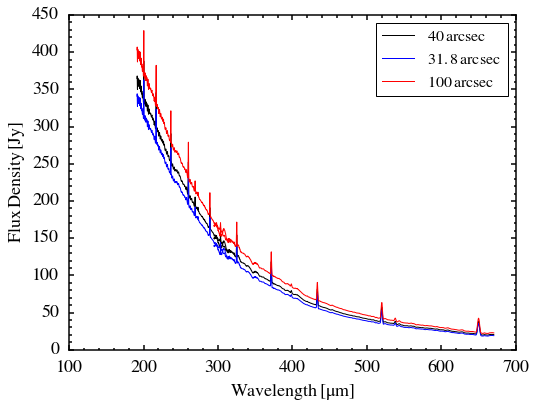

In [3]:
# use BHR71 as an example
# default - 40"
default = fits.open('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/bhr71_SECT_pacs_default.fits')
default_slw = [c/1e5/default[2].data.field(0), default[2].data.field(1)]
default_ssw = [c/1e5/default[3].data.field(0), default[3].data.field(1)]
# equivalent aperture as PACS 3x3 - 31.8"
pacs_equi = fits.open('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/bhr71_SECT_pacs_equi.fits')
equi_slw = [c/1e5/pacs_equi[2].data.field(0), pacs_equi[2].data.field(1)]
equi_ssw = [c/1e5/pacs_equi[3].data.field(0), pacs_equi[3].data.field(1)]
# extreme large aperture - 100"
large = fits.open('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/bhr71_SECT_pacs_large.fits')
large_slw = [c/1e5/large[2].data.field(0), large[2].data.field(1)]
large_ssw = [c/1e5/large[3].data.field(0), large[3].data.field(1)]

# plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(default_slw[0], default_slw[1], color='k', label=r'$\rm{40\,arcsec}$')
ax.plot(default_ssw[0], default_ssw[1], color='k')
ax.plot(equi_slw[0], equi_slw[1], color='b', label=r'$\rm{31.8\,arcsec}$')
ax.plot(equi_ssw[0], equi_ssw[1], color='b')
ax.plot(large_slw[0], large_slw[1], color='r', label=r'$\rm{100\,arcsec}$')
ax.plot(large_ssw[0], large_ssw[1], color='r')

ax.legend(loc='best', numpoints=1, fontsize=16)
ax.set_xlabel(r'$\rm{Wavelength\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Flux\,Density\,[Jy]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)

### show the effect of the Gaussian Reference Beam on matching with PACS spectrum

### BHR71

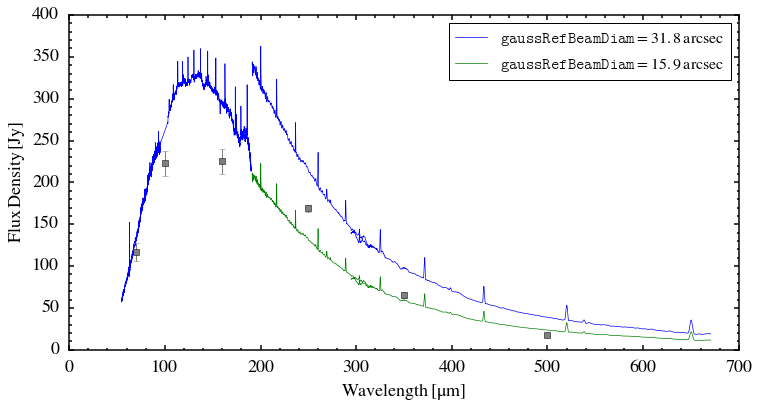

In [7]:
# read in BHR71 PACS spectrum
bhr71_pacs = ascii.read(
        '/Users/yaolun/bhr71/fitting/BHR71/pacs/data/BHR71_centralSpaxel_PointSourceCorrected_CorrectedYES_trim.txt')

# equivalent aperture as PACS 3x3 - 31.8"
pacs_equi = fits.open('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/bhr71_SECT_pacs_equi.fits')
equi_slw = [c/1e5/pacs_equi[2].data.field(0), pacs_equi[2].data.field(1)]
equi_ssw = [c/1e5/pacs_equi[3].data.field(0), pacs_equi[3].data.field(1)]

# equivalent aperture as PACS 3x3, but half - 15.9" (suspect HIPE messed up that the diameter is actually the radius)
pacs_equi_half = fits.open('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/bhr71_SECT_159.fits')
equi_half_slw = [c/1e5/pacs_equi_half[2].data.field(0), pacs_equi_half[2].data.field(1)]
equi_half_ssw = [c/1e5/pacs_equi_half[3].data.field(0), pacs_equi_half[3].data.field(1)]

# Calculate the photometry from spectrum with SPIRE photometry filter function
spire_equi_half = [np.hstack((bhr71_pacs['Wavelength(um)'],equi_half_slw[0], equi_half_ssw[0])),
                   np.hstack((bhr71_pacs['Flux(Jy)'],equi_half_slw[1], equi_half_ssw[1]))]
sorter = np.argsort(spire_equi_half[0])
spire_equi_half = [spire_equi_half[0][sorter], spire_equi_half[1][sorter]]
f = interp1d(spire_equi_half[0], spire_equi_half[1])

spire_phot = []
for wave in [250, 350, 500]:
    if wave == 250:
        fil_name = 'Herschel SPIRE 250um'
    elif wave == 350:
        fil_name = 'Herschel SPIRE 350um'
    elif wave == 500:
        fil_name = 'Herschel SPIRE 500um'
    filter_func = phot_filter(fil_name)
    filter_func = filter_func[(filter_func['wave']/1e4 >= min(spire_equi_half[0]))*\
                              ((filter_func['wave']/1e4 >= 54.8)+(filter_func['wave']/1e4 <= 36.0853))*\
                              ((filter_func['wave']/1e4 <= 95.05)+(filter_func['wave']/1e4 >=103))*\
                              ((filter_func['wave']/1e4 <= 190.31)+(filter_func['wave']/1e4 >= 195))*\
                              (filter_func['wave']/1e4 <= max(spire_equi_half[0]))]
    spire_phot.append(np.trapz(f(filter_func['wave']/1e4)*filter_func['transmission'], x=filter_func['wave']/1e4 )/\
                    np.trapz(filter_func['transmission'], x=filter_func['wave']/1e4))

    
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.plot(bhr71_pacs['Wavelength(um)'], bhr71_pacs['Flux(Jy)'], linewidth=0.7)
equi, = ax.plot(equi_slw[0], equi_slw[1], color='b', linewidth=0.7)
ax.plot(equi_ssw[0], equi_ssw[1], color='b', linewidth=0.7)
equi_half, = ax.plot(equi_half_slw[0], equi_half_slw[1], color='g', linewidth=0.7)
ax.plot(equi_half_ssw[0], equi_half_ssw[1], color='g', linewidth=0.7)

ax.errorbar(phot[(phot['Source'] == 'BHR71') & (phot['Aperture(diam.)'] == 31.8)]['Band'],
            phot[(phot['Source'] == 'BHR71') & (phot['Aperture(diam.)'] == 31.8)]['Flux'],
            yerr=phot[(phot['Source'] == 'BHR71') & (phot['Aperture(diam.)'] == 31.8)]['Uncertainty'],
            fmt='s', color='Grey')
# specphot, = ax.plot([250, 350, 500], spire_phot, marker='s', linestyle='None', color='r')

ax.legend([equi, equi_half],
          [r'$\tt{gaussRefBeamDiam}\rm{=31.8\,arcsec}$', r'$\tt{gaussRefBeamDiam}\rm{=15.9\,arcsec}$'],
          loc='best', numpoints=1, fontsize=16)
ax.set_xlabel(r'$\rm{Wavelength\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Flux\,Density\,[Jy]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)

fig.savefig('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/bhr71.pdf', format='pdf', dpi=300, bboxinches='tight')

### L1551-IRS5

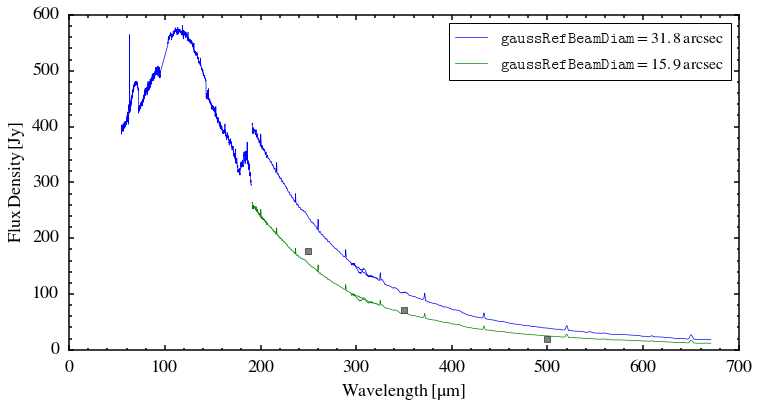

In [132]:
# read in L1551-IRS5 PACS spectrum
bhr71_pacs = ascii.read(
        '/Users/yaolun/data/CDF_archive/L1551-IRS5_centralSpaxel_PointSourceCorrected_CorrectedYES_trim.txt')

# equivalent aperture as PACS 3x3 - 31.8"
pacs_equi = fits.open('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/L1551-IRS5_318.fits')
equi_slw = [c/1e5/pacs_equi[2].data.field(0), pacs_equi[2].data.field(1)]
equi_ssw = [c/1e5/pacs_equi[3].data.field(0), pacs_equi[3].data.field(1)]

# equivalent aperture as PACS 3x3, but half - 15.9" (suspect HIPE messed up that the diameter is actually the radius)
pacs_equi_half = fits.open('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/L1551-IRS5_159.fits')
equi_half_slw = [c/1e5/pacs_equi_half[2].data.field(0), pacs_equi_half[2].data.field(1)]
equi_half_ssw = [c/1e5/pacs_equi_half[3].data.field(0), pacs_equi_half[3].data.field(1)]

# Calculate the photometry from spectrum with SPIRE photometry filter function
spire_equi_half = [np.hstack((bhr71_pacs['Wavelength(um)'],equi_half_slw[0], equi_half_ssw[0])),
                   np.hstack((bhr71_pacs['Flux(Jy)'],equi_half_slw[1], equi_half_ssw[1]))]
sorter = np.argsort(spire_equi_half[0])
spire_equi_half = [spire_equi_half[0][sorter], spire_equi_half[1][sorter]]
f = interp1d(spire_equi_half[0], spire_equi_half[1])

spire_phot = []
for wave in [250, 350, 500]:
    if wave == 250:
        fil_name = 'Herschel SPIRE 250um'
    elif wave == 350:
        fil_name = 'Herschel SPIRE 350um'
    elif wave == 500:
        fil_name = 'Herschel SPIRE 500um'
    filter_func = phot_filter(fil_name)
    filter_func = filter_func[(filter_func['wave']/1e4 >= min(spire_equi_half[0]))*\
                              ((filter_func['wave']/1e4 >= 54.8)+(filter_func['wave']/1e4 <= 36.0853))*\
                              ((filter_func['wave']/1e4 <= 95.05)+(filter_func['wave']/1e4 >=103))*\
                              ((filter_func['wave']/1e4 <= 190.31)+(filter_func['wave']/1e4 >= 195))*\
                              (filter_func['wave']/1e4 <= max(spire_equi_half[0]))]
    spire_phot.append(np.trapz(f(filter_func['wave']/1e4)*filter_func['transmission'], x=filter_func['wave']/1e4 )/\
                    np.trapz(filter_func['transmission'], x=filter_func['wave']/1e4))

    
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.plot(bhr71_pacs['Wavelength(um)'], bhr71_pacs['Flux(Jy)'], linewidth=0.7)
equi, = ax.plot(equi_slw[0], equi_slw[1], color='b', linewidth=0.7)
ax.plot(equi_ssw[0], equi_ssw[1], color='b', linewidth=0.7)
equi_half, = ax.plot(equi_half_slw[0], equi_half_slw[1], color='g', linewidth=0.7)
ax.plot(equi_half_ssw[0], equi_half_ssw[1], color='g', linewidth=0.7)

ax.errorbar(phot[(phot['Source'] == 'L1551-IRS5') & (phot['Aperture(diam.)'] == 31.8)]['Band'],
            phot[(phot['Source'] == 'L1551-IRS5') & (phot['Aperture(diam.)'] == 31.8)]['Flux'],
            yerr=phot[(phot['Source'] == 'L1551-IRS5') & (phot['Aperture(diam.)'] == 31.8)]['Uncertainty'],
            fmt='s', color='Grey')
# specphot, = ax.plot([250, 350, 500], spire_phot, marker='s', linestyle='None', color='r')

ax.legend([equi, equi_half],
          [r'$\tt{gaussRefBeamDiam}\rm{=31.8\,arcsec}$', r'$\tt{gaussRefBeamDiam}\rm{=15.9\,arcsec}$'],
          loc='best', numpoints=1, fontsize=16)
ax.set_xlabel(r'$\rm{Wavelength\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Flux\,Density\,[Jy]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
fig.savefig('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/l1551-irs5.pdf', format='pdf', dpi=300, bboxinches='tight')

### B335

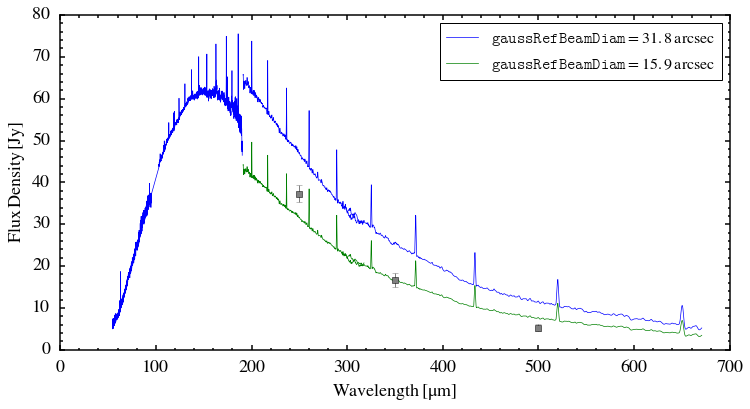

In [133]:
# read in B335 PACS spectrum
bhr71_pacs = ascii.read(
        '/Users/yaolun/data/CDF_archive/B335_centralSpaxel_PointSourceCorrected_CorrectedYES_trim.txt')

# equivalent aperture as PACS 3x3 - 31.8"
pacs_equi = fits.open('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/B335_318.fits')
equi_slw = [c/1e5/pacs_equi[2].data.field(0), pacs_equi[2].data.field(1)]
equi_ssw = [c/1e5/pacs_equi[3].data.field(0), pacs_equi[3].data.field(1)]

# equivalent aperture as PACS 3x3, but half - 15.9" (suspect HIPE messed up that the diameter is actually the radius)
pacs_equi_half = fits.open('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/B335_159.fits')
equi_half_slw = [c/1e5/pacs_equi_half[2].data.field(0), pacs_equi_half[2].data.field(1)]
equi_half_ssw = [c/1e5/pacs_equi_half[3].data.field(0), pacs_equi_half[3].data.field(1)]

# Calculate the photometry from spectrum with SPIRE photometry filter function
spire_equi_half = [np.hstack((bhr71_pacs['Wavelength(um)'],equi_half_slw[0], equi_half_ssw[0])),
                   np.hstack((bhr71_pacs['Flux(Jy)'],equi_half_slw[1], equi_half_ssw[1]))]
sorter = np.argsort(spire_equi_half[0])
spire_equi_half = [spire_equi_half[0][sorter], spire_equi_half[1][sorter]]
f = interp1d(spire_equi_half[0], spire_equi_half[1])

spire_phot = []
for wave in [250, 350, 500]:
    if wave == 250:
        fil_name = 'Herschel SPIRE 250um'
    elif wave == 350:
        fil_name = 'Herschel SPIRE 350um'
    elif wave == 500:
        fil_name = 'Herschel SPIRE 500um'
    filter_func = phot_filter(fil_name)
    filter_func = filter_func[(filter_func['wave']/1e4 >= min(spire_equi_half[0]))*\
                              ((filter_func['wave']/1e4 >= 54.8)+(filter_func['wave']/1e4 <= 36.0853))*\
                              ((filter_func['wave']/1e4 <= 95.05)+(filter_func['wave']/1e4 >=103))*\
                              ((filter_func['wave']/1e4 <= 190.31)+(filter_func['wave']/1e4 >= 195))*\
                              (filter_func['wave']/1e4 <= max(spire_equi_half[0]))]
    spire_phot.append(np.trapz(f(filter_func['wave']/1e4)*filter_func['transmission'], x=filter_func['wave']/1e4 )/\
                    np.trapz(filter_func['transmission'], x=filter_func['wave']/1e4))

    
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.plot(bhr71_pacs['Wavelength(um)'], bhr71_pacs['Flux(Jy)'], linewidth=0.7)
equi, = ax.plot(equi_slw[0], equi_slw[1], color='b', linewidth=0.7)
ax.plot(equi_ssw[0], equi_ssw[1], color='b', linewidth=0.7)
equi_half, = ax.plot(equi_half_slw[0], equi_half_slw[1], color='g', linewidth=0.7)
ax.plot(equi_half_ssw[0], equi_half_ssw[1], color='g', linewidth=0.7)

ax.errorbar(phot[(phot['Source'] == 'B335') & (phot['Aperture(diam.)'] == 31.8)]['Band'],
            phot[(phot['Source'] == 'B335') & (phot['Aperture(diam.)'] == 31.8)]['Flux'],
            yerr=phot[(phot['Source'] == 'B335') & (phot['Aperture(diam.)'] == 31.8)]['Uncertainty'],
            fmt='s', color='Grey')
# specphot, = ax.plot([250, 350, 500], spire_phot, marker='s', linestyle='None', color='r')

ax.legend([equi, equi_half],
          [r'$\tt{gaussRefBeamDiam}\rm{=31.8\,arcsec}$', r'$\tt{gaussRefBeamDiam}\rm{=15.9\,arcsec}$'],
          loc='best', numpoints=1, fontsize=16)
ax.set_xlabel(r'$\rm{Wavelength\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Flux\,Density\,[Jy]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
fig.savefig('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/b335.pdf', format='pdf', dpi=300, bboxinches='tight')

### HD 100546

(0, 100)

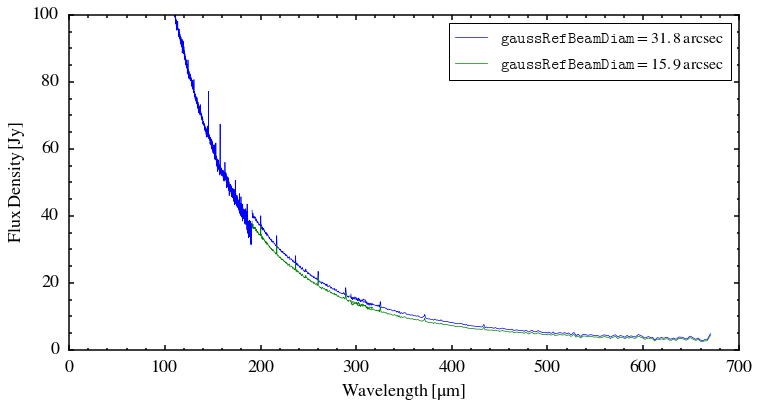

In [130]:
# read in B335 PACS spectrum
bhr71_pacs = ascii.read(
        '/Users/yaolun/data/CDF_archive/HD100546_centralSpaxel_PointSourceCorrected_CorrectedYES_trim.txt')

# equivalent aperture as PACS 3x3 - 31.8"
pacs_equi = fits.open('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/HD100546_318.fits')
equi_slw = [c/1e5/pacs_equi[2].data.field(0), pacs_equi[2].data.field(1)]
equi_ssw = [c/1e5/pacs_equi[3].data.field(0), pacs_equi[3].data.field(1)]

# equivalent aperture as PACS 3x3, but half - 15.9" (suspect HIPE messed up that the diameter is actually the radius)
pacs_equi_half = fits.open('/Users/yaolun/bhr71/bhr71_SECT/SECT_gaussRefBeamDiam_test/HD100546_159.fits')
equi_half_slw = [c/1e5/pacs_equi_half[2].data.field(0), pacs_equi_half[2].data.field(1)]
equi_half_ssw = [c/1e5/pacs_equi_half[3].data.field(0), pacs_equi_half[3].data.field(1)]

# Calculate the photometry from spectrum with SPIRE photometry filter function
spire_equi_half = [np.hstack((bhr71_pacs['Wavelength(um)'],equi_half_slw[0], equi_half_ssw[0])),
                   np.hstack((bhr71_pacs['Flux(Jy)'],equi_half_slw[1], equi_half_ssw[1]))]
sorter = np.argsort(spire_equi_half[0])
spire_equi_half = [spire_equi_half[0][sorter], spire_equi_half[1][sorter]]
f = interp1d(spire_equi_half[0], spire_equi_half[1])

spire_phot = []
for wave in [250, 350, 500]:
    if wave == 250:
        fil_name = 'Herschel SPIRE 250um'
    elif wave == 350:
        fil_name = 'Herschel SPIRE 350um'
    elif wave == 500:
        fil_name = 'Herschel SPIRE 500um'
    filter_func = phot_filter(fil_name)
    filter_func = filter_func[(filter_func['wave']/1e4 >= min(spire_equi_half[0]))*\
                              ((filter_func['wave']/1e4 >= 54.8)+(filter_func['wave']/1e4 <= 36.0853))*\
                              ((filter_func['wave']/1e4 <= 95.05)+(filter_func['wave']/1e4 >=103))*\
                              ((filter_func['wave']/1e4 <= 190.31)+(filter_func['wave']/1e4 >= 195))*\
                              (filter_func['wave']/1e4 <= max(spire_equi_half[0]))]
    spire_phot.append(np.trapz(f(filter_func['wave']/1e4)*filter_func['transmission'], x=filter_func['wave']/1e4 )/\
                    np.trapz(filter_func['transmission'], x=filter_func['wave']/1e4))

    
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.plot(bhr71_pacs['Wavelength(um)'], bhr71_pacs['Flux(Jy)'], linewidth=0.7)
equi, = ax.plot(equi_slw[0], equi_slw[1], color='b', linewidth=0.7)
ax.plot(equi_ssw[0], equi_ssw[1], color='b', linewidth=0.7)
equi_half, = ax.plot(equi_half_slw[0], equi_half_slw[1], color='g', linewidth=0.7)
ax.plot(equi_half_ssw[0], equi_half_ssw[1], color='g', linewidth=0.7)

ax.errorbar(phot[(phot['Source'] == 'HD100546') & (phot['Aperture(diam.)'] == 31.8)]['Band'],
            phot[(phot['Source'] == 'HD100546') & (phot['Aperture(diam.)'] == 31.8)]['Flux'],
            yerr=phot[(phot['Source'] == 'HD100546') & (phot['Aperture(diam.)'] == 31.8)]['Uncertainty'],
            fmt='s', color='Grey')
# specphot, = ax.plot([250, 350, 500], spire_phot, marker='s', linestyle='None', color='r')

ax.legend([equi, equi_half],
          [r'$\tt{gaussRefBeamDiam}\rm{=31.8\,arcsec}$', r'$\tt{gaussRefBeamDiam}\rm{=15.9\,arcsec}$'],
          loc='best', numpoints=1, fontsize=16)
ax.set_xlabel(r'$\rm{Wavelength\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Flux\,Density\,[Jy]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_ylim([0,100])

### Read in the photometry data

In [5]:
phot = ascii.read('/Users/yaolun/Google Drive/Papers/yaolun/bhr71/SECT_phot_summary.txt')

In [6]:
phot

Source,Band,Aperture(diam.),Flux,Uncertainty
str10,int64,float64,float64,float64
BHR71,70,22.75,126.02,11.23
BHR71,100,22.75,245.35,15.66
BHR71,160,22.75,271.25,16.47
BHR71,250,22.75,221.4,4.92
BHR71,350,22.75,100.0,4.03
BHR71,500,22.75,30.62,2.15
BHR71,70,11.35,105.05,10.25
BHR71,100,11.35,190.63,13.81
BHR71,160,11.35,176.15,13.27


In [66]:
phot[(phot['Source'] == 'BHR71') & (phot['Aperture(diam.)'] == 22.75)]

Source,Band,Aperture(diam.),Flux,Uncertainty
str5,int64,float64,float64,float64
BHR71,70,22.75,126.02,11.23
BHR71,100,22.75,245.35,15.66
BHR71,160,22.75,271.25,16.47
BHR71,250,22.75,221.4,4.92
BHR71,350,22.75,100.0,4.03
BHR71,500,22.75,30.62,2.15


## BHR71

In [55]:
# read in the SECT-corrected spectrum with gaussRefBeamDiam = 23.75"
bhr71_sect = fits.open('/Users/yaolun/data/herschel/BHR71/bhr71_spire_SECT_2375.fits')
bhr71_spec_slw = [c/1e5/bhr71_sect[2].data.field(0), bhr71_sect[2].data.field(1)]
bhr71_spec_ssw = [c/1e5/bhr71_sect[3].data.field(0), bhr71_sect[3].data.field(1)]

# read in BHR71 PACS spectrum
bhr71_pacs = ascii.read(
        '/Users/yaolun/bhr71/fitting/BHR71/pacs/data/BHR71_centralSpaxel_PointSourceCorrected_CorrectedYES_trim.txt')

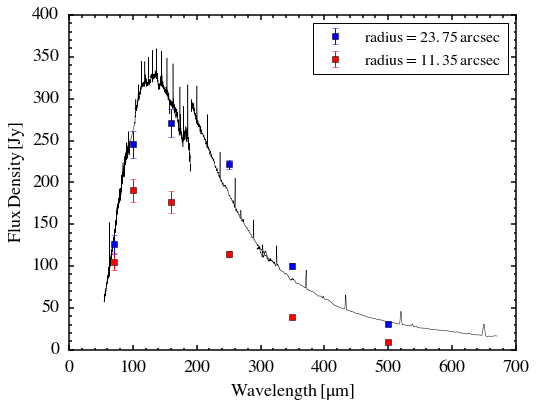

In [81]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(bhr71_pacs['Wavelength(um)'], bhr71_pacs['Flux(Jy)'], color='k', linewidth=0.5)
ax.plot(bhr71_spec_ssw[0], bhr71_spec_ssw[1], color='k', linewidth=0.5)
ax.plot(bhr71_spec_slw[0], bhr71_spec_slw[1], color='k', linewidth=0.5)

# plot photometry
full_aper = ax.errorbar(phot[(phot['Source'] == 'BHR71') & (phot['Aperture(diam.)'] == 22.75)]['Band'],
            phot[(phot['Source'] == 'BHR71') & (phot['Aperture(diam.)'] == 22.75)]['Flux'],
            yerr=phot[(phot['Source'] == 'BHR71') & (phot['Aperture(diam.)'] == 22.75)]['Uncertainty'],
            fmt='s', color='b', label=r'$\rm{aperture=23.75"}$')
half_aper = ax.errorbar(phot[(phot['Source'] == 'BHR71') & (phot['Aperture(diam.)'] == 11.35)]['Band'],
            phot[(phot['Source'] == 'BHR71') & (phot['Aperture(diam.)'] == 11.35)]['Flux'],
            yerr=phot[(phot['Source'] == 'BHR71') & (phot['Aperture(diam.)'] == 11.35)]['Uncertainty'],
            fmt='s', color='r', label=r'$\rm{aperture=11.35}"$')

ax.legend([full_aper, half_aper], [r'$\rm{radius=23.75\,arcsec}$', r'$\rm{radius=11.35\,arcsec}$'],
          loc='best', numpoints=1, fontsize=16)
ax.set_xlabel(r'$\rm{Wavelength\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Flux\,Density\,[Jy]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
